# Solar Flare Prediction


![Solar-Flare](faq25.jpg)

## Goal
- The goal of this project is to use an existing dataset to better predict the occurance of a solar flare within a 24 hour period

First we need to import X_dataset.csv and provide labels to the dataset

In [26]:
import pyspark
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold, cross_val_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.neighbors import KNeighborsClassifier

headers = ['class', 'largestSpot', 'spotDistribution', 'activity', 'evolution', 'previousActivity', 'complex',
           'complexOnPath', 'area', 'largestSpotArea', 'c-class', 'm-class', 'x-class']

df = pd.read_csv('training_data/SolarFlare_Clean.csv', header=None, names=headers)

df.head()

,class,largestSpot,spotDistribution,activity,evolution,previousActivity,complex,complexOnPath,area,largestSpotArea,c-class,m-class,x-class
0,H,A,X,1,3,1,1,1,1,1,0,0,0
1,D,R,O,1,3,1,1,2,1,1,0,0,0
2,C,S,O,1,3,1,1,2,1,1,0,0,0
3,H,R,X,1,2,1,1,1,1,1,0,0,0
4,H,S,X,1,1,1,1,2,1,1,0,0,0


From this point we will do Data Transformation to convert values to floating point numbers

In [27]:
# Class: (A,B,C,D,E,F,H) (0,1,2,3,4,5,6)
class_map = {'A': 0, 'B': 1, 'C': 2, 'D': 3, 'E': 4, 'F': 5, 'H': 6, }
df['class'] = df['class'].map(class_map)

# Largest Spot: (X,R,S,A,H,K) (0,1,2,3,4,5)
largest_spot_map = {'X': 0, 'R': 1, 'S': 2, 'A': 3, 'H': 4, 'K': 5}
df['largestSpot'] = df['largestSpot'].map(largest_spot_map)

# Spot Distribution: (X,O,I,C) (0,1,2,3)
spot_distribution_map = {'X': 0, 'O': 1, 'I': 2, 'C': 3}
df['spotDistribution'] = df['spotDistribution'].map(spot_distribution_map)

df.head()


,class,largestSpot,spotDistribution,activity,evolution,previousActivity,complex,complexOnPath,area,largestSpotArea,c-class,m-class,x-class
0,6,3,0,1,3,1,1,1,1,1,0,0,0
1,3,1,1,1,3,1,1,2,1,1,0,0,0
2,2,2,1,1,3,1,1,2,1,1,0,0,0
3,6,1,0,1,2,1,1,1,1,1,0,0,0
4,6,2,0,1,1,1,1,2,1,1,0,0,0


Before running any analysis on the data we want to remove any duplicated/noisy data. We will do this using the 'duplicated()' method which looks for duplicated data and returns a true value if duplicates are found aka contain the same values. For any values that return true the 'drop_duplicates()' method will remove these duplicates.

In [28]:
print("Number of duplicated rows: {}.".format(df.duplicated().sum()))

Number of duplicated rows: 701.


In [29]:
dp = df[df.duplicated(keep=False)]
df.drop_duplicates(inplace= True)
print("Number of duplicated rows: {}.".format(df.duplicated().sum()))

Number of duplicated rows: 0.


We want to create a 5 number summary of the dataset using 'describe()' which generates descriptive stats

In [30]:
df.describe().T

,count,mean,std,min,25%,50%,75%,max
class,365.0,3.616438,1.462255,1.0,3.0,3.0,5.0,6.0
largestSpot,365.0,2.493151,1.297962,0.0,2.0,2.0,3.0,5.0
spotDistribution,365.0,1.386301,0.862101,0.0,1.0,1.0,2.0,3.0
activity,365.0,1.361644,0.481136,1.0,1.0,1.0,2.0,2.0
evolution,365.0,2.378082,0.650073,1.0,2.0,2.0,3.0,3.0
previousActivity,365.0,1.164384,0.519237,1.0,1.0,1.0,1.0,3.0
complex,365.0,1.616438,0.486921,1.0,1.0,2.0,2.0,2.0
complexOnPath,365.0,1.934247,0.248191,1.0,2.0,2.0,2.0,2.0
area,365.0,1.068493,0.252937,1.0,1.0,1.0,1.0,2.0
largestSpotArea,365.0,1.000000,0.000000,1.0,1.0,1.0,1.0,1.0


We also want to graph the results of this analysis using a box plot

In [31]:
df.boxplot(figsize=(20, 10))

<AxesSubplot:>

Now because the standard deviation of largestSpotArea is 0 we will drop it because it adds no significance to the dataset

In [32]:
df.drop(['largestSpotArea'] , axis=1, inplace=True)

In [33]:
df.head()

,class,largestSpot,spotDistribution,activity,evolution,previousActivity,complex,complexOnPath,area,c-class,m-class,x-class
0,6,3,0,1,3,1,1,1,1,0,0,0
1,3,1,1,1,3,1,1,2,1,0,0,0
2,2,2,1,1,3,1,1,2,1,0,0,0
3,6,1,0,1,2,1,1,1,1,0,0,0
4,6,2,0,1,1,1,1,2,1,0,0,0


We will first do correlation analysis of X-Class flares using the corr() method which computes pairwise correlation of columns, excluding NA/null values. Using the Pearson method

In [34]:
# Correlation report for x-class flares
x_class = df.drop(["c-class", "m-class"], axis=1)
x_class.corr('pearson')

,class,largestSpot,spotDistribution,activity,evolution,previousActivity,complex,complexOnPath,area,x-class
class,1.000000,0.295346,-0.320178,-0.024874,-0.031989,-0.014424,0.097625,-0.433039,0.138077,0.029347
largestSpot,0.295346,1.000000,0.354685,0.206338,0.175642,0.189187,0.291420,0.015654,0.440755,0.187348
spotDistribution,-0.320178,0.354685,1.000000,0.331218,0.189662,0.164613,0.314678,0.427192,0.382278,0.187789
activity,-0.024874,0.206338,0.331218,1.000000,0.053519,0.377204,0.230195,0.153669,0.179668,0.109683
evolution,-0.031989,0.175642,0.189662,0.053519,1.000000,-0.005575,-0.130782,-0.015768,0.126111,0.049666
previousActivity,-0.014424,0.189187,0.164613,0.377204,-0.005575,1.000000,0.152275,0.084104,0.206888,0.108226
complex,0.097625,0.291420,0.314678,0.230195,-0.130782,0.152275,1.000000,0.177192,0.213896,0.088131
complexOnPath,-0.433039,0.015654,0.427192,0.153669,-0.015768,0.084104,0.177192,1.000000,0.071938,0.029640
area,0.138077,0.440755,0.382278,0.179668,0.126111,0.206888,0.213896,0.071938,1.000000,0.338304
x-class,0.029347,0.187348,0.187789,0.109683,0.049666,0.108226,0.088131,0.029640,0.338304,1.000000


In [35]:
# Correlation report for m-class flares
m_class = df.drop(["c-class", "x-class"], axis=1)
m_class.corr('pearson')

,class,largestSpot,spotDistribution,activity,evolution,previousActivity,complex,complexOnPath,area,m-class
class,1.000000,0.295346,-0.320178,-0.024874,-0.031989,-0.014424,0.097625,-0.433039,0.138077,-0.024666
largestSpot,0.295346,1.000000,0.354685,0.206338,0.175642,0.189187,0.291420,0.015654,0.440755,0.144774
spotDistribution,-0.320178,0.354685,1.000000,0.331218,0.189662,0.164613,0.314678,0.427192,0.382278,0.180689
activity,-0.024874,0.206338,0.331218,1.000000,0.053519,0.377204,0.230195,0.153669,0.179668,0.041425
evolution,-0.031989,0.175642,0.189662,0.053519,1.000000,-0.005575,-0.130782,-0.015768,0.126111,0.125060
previousActivity,-0.014424,0.189187,0.164613,0.377204,-0.005575,1.000000,0.152275,0.084104,0.206888,0.096034
complex,0.097625,0.291420,0.314678,0.230195,-0.130782,0.152275,1.000000,0.177192,0.213896,0.060829
complexOnPath,-0.433039,0.015654,0.427192,0.153669,-0.015768,0.084104,0.177192,1.000000,0.071938,0.047554
area,0.138077,0.440755,0.382278,0.179668,0.126111,0.206888,0.213896,0.071938,1.000000,0.231828
m-class,-0.024666,0.144774,0.180689,0.041425,0.125060,0.096034,0.060829,0.047554,0.231828,1.000000


In [36]:
# Correlation report for c-class flares
c_class = df.drop(["x-class", "m-class"], axis=1)
c_class.corr('pearson')

,class,largestSpot,spotDistribution,activity,evolution,previousActivity,complex,complexOnPath,area,c-class
class,1.000000,0.295346,-0.320178,-0.024874,-0.031989,-0.014424,0.097625,-0.433039,0.138077,0.008289
largestSpot,0.295346,1.000000,0.354685,0.206338,0.175642,0.189187,0.291420,0.015654,0.440755,0.192622
spotDistribution,-0.320178,0.354685,1.000000,0.331218,0.189662,0.164613,0.314678,0.427192,0.382278,0.237394
activity,-0.024874,0.206338,0.331218,1.000000,0.053519,0.377204,0.230195,0.153669,0.179668,0.116492
evolution,-0.031989,0.175642,0.189662,0.053519,1.000000,-0.005575,-0.130782,-0.015768,0.126111,0.100831
previousActivity,-0.014424,0.189187,0.164613,0.377204,-0.005575,1.000000,0.152275,0.084104,0.206888,0.073546
complex,0.097625,0.291420,0.314678,0.230195,-0.130782,0.152275,1.000000,0.177192,0.213896,0.065274
complexOnPath,-0.433039,0.015654,0.427192,0.153669,-0.015768,0.084104,0.177192,1.000000,0.071938,0.110985
area,0.138077,0.440755,0.382278,0.179668,0.126111,0.206888,0.213896,0.071938,1.000000,0.083061
c-class,0.008289,0.192622,0.237394,0.116492,0.100831,0.073546,0.065274,0.110985,0.083061,1.000000


Now running full correlation analysis on all classes

In [37]:
df.corr('pearson')

,class,largestSpot,spotDistribution,activity,evolution,previousActivity,complex,complexOnPath,area,c-class,m-class,x-class
class,1.000000,0.295346,-0.320178,-0.024874,-0.031989,-0.014424,0.097625,-0.433039,0.138077,0.008289,-0.024666,0.029347
largestSpot,0.295346,1.000000,0.354685,0.206338,0.175642,0.189187,0.291420,0.015654,0.440755,0.192622,0.144774,0.187348
spotDistribution,-0.320178,0.354685,1.000000,0.331218,0.189662,0.164613,0.314678,0.427192,0.382278,0.237394,0.180689,0.187789
activity,-0.024874,0.206338,0.331218,1.000000,0.053519,0.377204,0.230195,0.153669,0.179668,0.116492,0.041425,0.109683
evolution,-0.031989,0.175642,0.189662,0.053519,1.000000,-0.005575,-0.130782,-0.015768,0.126111,0.100831,0.125060,0.049666
previousActivity,-0.014424,0.189187,0.164613,0.377204,-0.005575,1.000000,0.152275,0.084104,0.206888,0.073546,0.096034,0.108226
complex,0.097625,0.291420,0.314678,0.230195,-0.130782,0.152275,1.000000,0.177192,0.213896,0.065274,0.060829,0.088131
complexOnPath,-0.433039,0.015654,0.427192,0.153669,-0.015768,0.084104,0.177192,1.000000,0.071938,0.110985,0.047554,0.029640
area,0.138077,0.440755,0.382278,0.179668,0.126111,0.206888,0.213896,0.071938,1.000000,0.083061,0.231828,0.338304
c-class,0.008289,0.192622,0.237394,0.116492,0.100831,0.073546,0.065274,0.110985,0.083061,1.000000,0.077413,-0.009669


Drop those attributes that are not statistically significant to each class

In [38]:
# Drop columns with low correlation to x-class, m-class, and c-class
df.drop(['class'], axis=1, inplace=True)

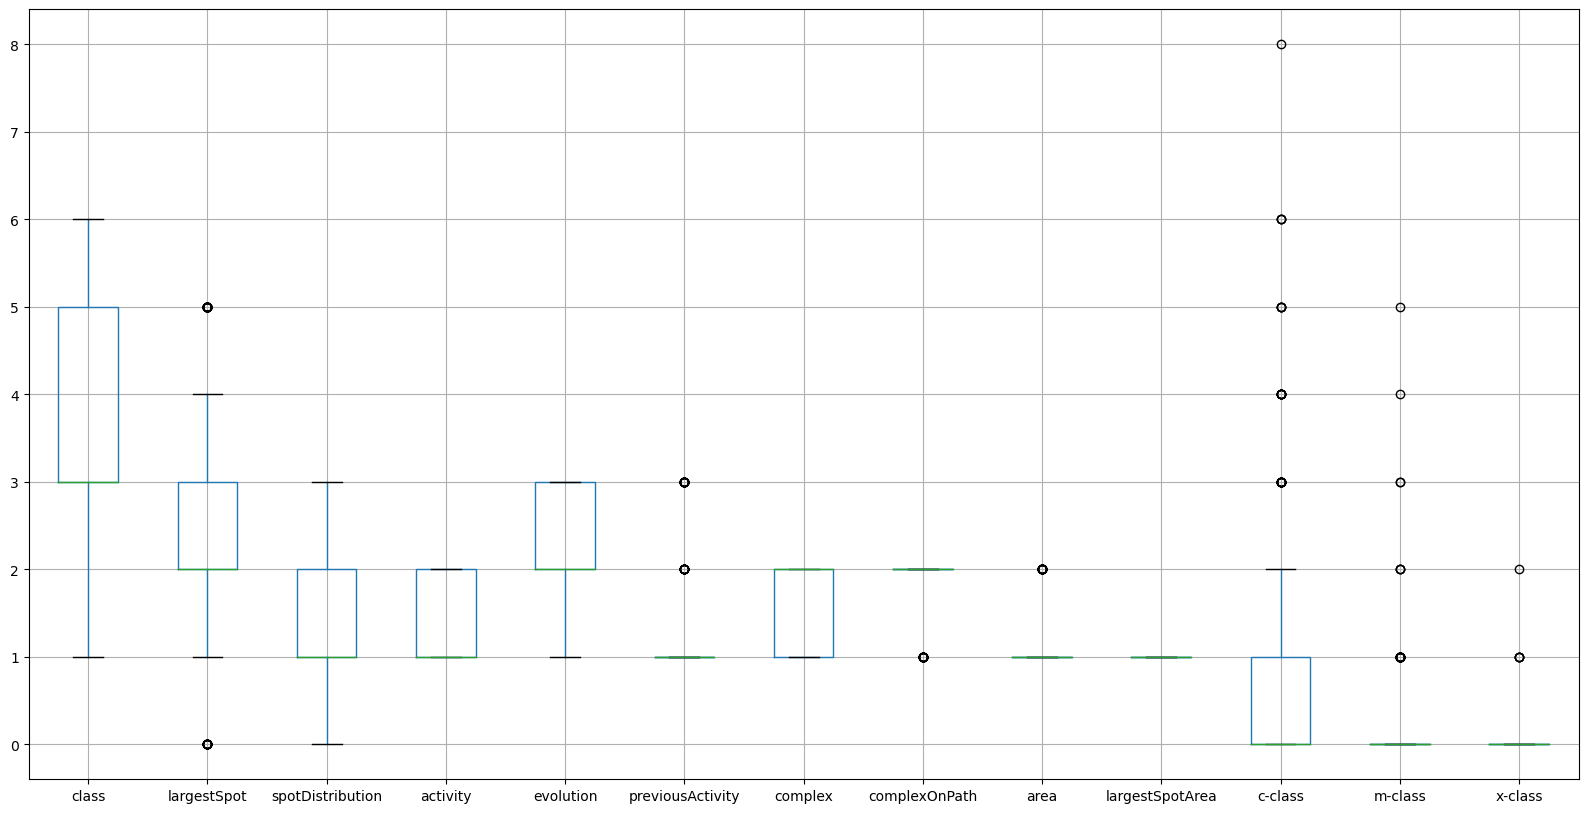

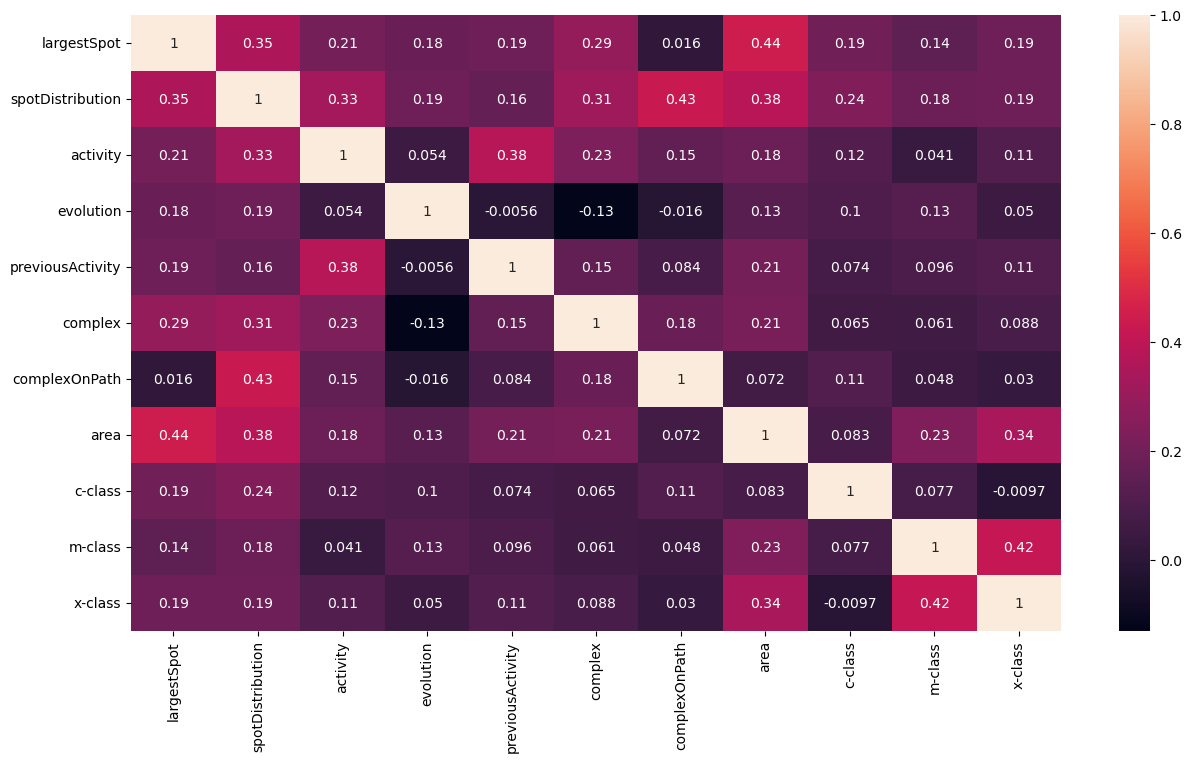

In [39]:
plt.figure(figsize=(15, 8))
sns.heatmap(df.corr('pearson'), annot=True)
plt.show()

Now we can compare the performance of different models on their accuracy of prediction for c-class, m-class, and x-class using data from RapidMiner

In [40]:
headers = ['Model', 'Accuracy', 'Standard Deviation', 'Gains', 'Total Time', 'Training Time (1,000 Rows)', 'Scoring Time (1,000 Rows)']
c_model = pd.read_csv('model_performance_analysis/c_class_results.csv', header=None, names=headers)
m_model = pd.read_csv('model_performance_analysis/m_class_results.csv', header=None, names=headers)
x_model = pd.read_csv('model_performance_analysis/x_class_performance.csv', header=None, names=headers)

In [41]:
c_model.head(6)

,Model,Accuracy,Standard Deviation,Gains,Total Time,"Training Time (1,000 Rows)","Scoring Time (1,000 Rows)"
0,Naive Bayes,0.996667,0.007454,0.0,5351.0,140.712946,199.530516
1,Generalized Linear Model,0.996667,0.007454,0.0,4469.0,97.560976,136.150235
2,Logistic Regression,0.996667,0.007454,0.0,4433.0,107.879925,150.234742
3,Deep Learning,0.996667,0.007454,0.0,6869.0,597.560976,166.666667
4,Decision Tree,0.996667,0.007454,0.0,4430.0,30.956848,119.718310
5,Random Forest,0.996667,0.007454,0.0,11832.0,96.622889,225.352113


In [42]:
m_model.head(6)

,Model,Accuracy,Standard Deviation,Gains,Total Time,"Training Time (1,000 Rows)","Scoring Time (1,000 Rows)"
0,Naive Bayes,0.996721,0.007331,0.0,5370.0,45.966229,168.618267
1,Generalized Linear Model,0.996721,0.007331,0.0,4904.0,85.365854,133.489461
2,Logistic Regression,0.996721,0.007331,0.0,4849.0,88.180113,135.831382
3,Deep Learning,0.996721,0.007331,0.0,7297.0,612.570356,163.934426
4,Decision Tree,0.996721,0.007331,0.0,4710.0,60.037523,163.934426
5,Random Forest,0.996721,0.007331,0.0,11809.0,29.080675,353.629977


In [43]:
x_model.head(6)

,Model,Accuracy,Standard Deviation,Gains,Total Time,"Training Time (1,000 Rows)","Scoring Time (1,000 Rows)"
0,Naive Bayes,1.0,0.0,0.0,6968.0,189.493433,1098.591549
1,Generalized Linear Model,1.0,0.0,0.0,5342.0,139.774859,664.319249
2,Logistic Regression,1.0,0.0,0.0,5233.0,146.341463,237.089202
3,Deep Learning,1.0,0.0,0.0,7354.0,659.474672,180.751174
4,Decision Tree,1.0,0.0,0.0,5181.0,38.461538,129.107981
5,Random Forest,1.0,0.0,0.0,11870.0,61.913696,239.436620


In [44]:
# Normalize using z-score
def normalize(df):
    result = df.copy()
    for feature_name in df.columns:
        mean = df[feature_name].mean()
        std = df[feature_name].std()
        result[feature_name] = (df[feature_name] - mean) / std
        # convert to int
        result[feature_name] = result[feature_name].astype(int)
    return result

In [45]:
normalized_df = normalize(df)

## Now it is time to test out various different models and determine which one has the best accuracy

Use cross-validation for testing

In [46]:
# Gradient Boosting Classifier function for x-class, c-class, and m-class
def gbc_model(df, class_name):
    # Use cross validation to split the data into training and testing sets
    X = df.drop([class_name], axis=1)
    y = df[class_name]
    
    # Create the model
    gbc = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=0)

    # Evaluate the model using cross validation
    kfold = KFold(n_splits=10, random_state=1, shuffle=True)
    results = cross_val_score(gbc, X, y, cv=kfold)

    # Train the model on the entire dataset
    gbc.fit(X, y)

    return gbc, results


Train the Gradient Boosting Classifier

In [47]:
# Gradient Boosting Classifier function call for x-class, c-class, and m-class
x_class_accuracy_gbc = gbc_model(normalized_df, 'x-class')
c_class_accuracy_gbc = gbc_model(normalized_df, 'c-class')
m_class_accuracy_gbc = gbc_model(normalized_df, 'm-class')

print("X-Class Accuracy: %.2f%% (%.2f%%)" % (x_class_accuracy_gbc[1].mean()*100, x_class_accuracy_gbc[1].std()*100))
print("C-Class Accuracy: %.2f%% (%.2f%%)" % (c_class_accuracy_gbc[1].mean()*100, c_class_accuracy_gbc[1].std()*100))
print("M-Class Accuracy: %.2f%% (%.2f%%)" % (m_class_accuracy_gbc[1].mean()*100, m_class_accuracy_gbc[1].std()*100))


X-Class Accuracy: 98.06% (2.79%)
C-Class Accuracy: 89.84% (5.84%)
M-Class Accuracy: 89.86% (2.76%)


In [48]:
# K Nearest Neighbors Model for the given class
def knn_model(df, class_name, k=5):

    X = df.drop([class_name], axis=1)
    y = df[class_name]

    mdl = KNeighborsClassifier(n_neighbors=k)

    # Find accuracy using cross validation, same as GBC above
    kfold = KFold(n_splits=10, random_state=1, shuffle=True)
    results = cross_val_score(mdl, X, y, cv=kfold)

    return results

    #return mdl.fit(X, y)

In [49]:
# Store the accuracy of each model
x_class_accuracy_knn = knn_model(normalized_df, 'x-class')
c_class_accuracy_knn = knn_model(normalized_df, 'c-class')
m_class_accuracy_knn = knn_model(normalized_df, 'm-class')

print("X-Class Accuracy: %.2f%% (%.2f%%)" % (x_class_accuracy_knn.mean()*100, x_class_accuracy_knn.std()*100))
print("C-Class Accuracy: %.2f%% (%.2f%%)" % (c_class_accuracy_knn.mean()*100, c_class_accuracy_knn.std()*100))
print("M-Class Accuracy: %.2f%% (%.2f%%)" % (m_class_accuracy_knn.mean()*100, m_class_accuracy_knn.std()*100))

X-Class Accuracy: 98.62% (2.23%)
C-Class Accuracy: 90.12% (5.44%)
M-Class Accuracy: 90.68% (2.82%)


/Users/ddalton/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no longer be accepted. Set `keepdims` to True or False to avoid this warning.
  mode, _ = stats.mode(_y[neigh_ind, k], axis=1)
/Users/ddalton/opt/anaconda3/lib/python3.9/site-packages/sklearn/neighbors/_classification.py:228: FutureWarning: Unlike other reduction functions (e.g. `skew`, `kurtosis`), the default behavior of `mode` typically preserves the axis it acts along. In SciPy 1.11.0, this behavior will change: the default value of `keepdims` will become False, the `axis` over which the statistic is taken will be eliminated, and the value None will no long

## Visualize the accuracy of these models

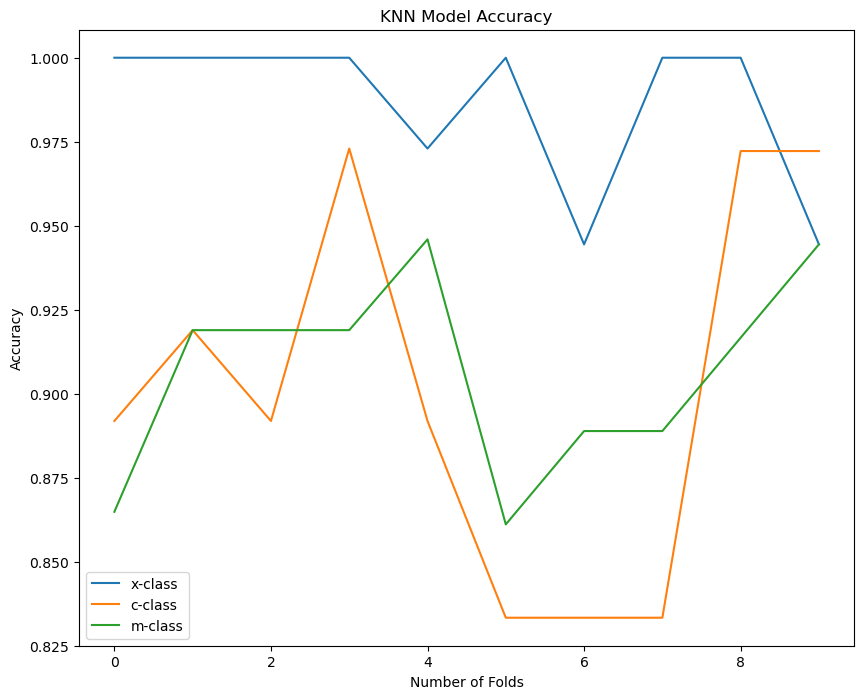

In [50]:
# Visualization of x_class_accuracy_knn, c_class_accuracy_knn, and m_class_accuracy_knn
def plot_accuracy():
    plt.figure(figsize=(10, 8))
    plt.plot(x_class_accuracy_knn, label='x-class')
    plt.plot(c_class_accuracy_knn, label='c-class')
    plt.plot(m_class_accuracy_knn, label='m-class')
    plt.title('KNN Model Accuracy')
    plt.xlabel('Number of Folds')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_accuracy()



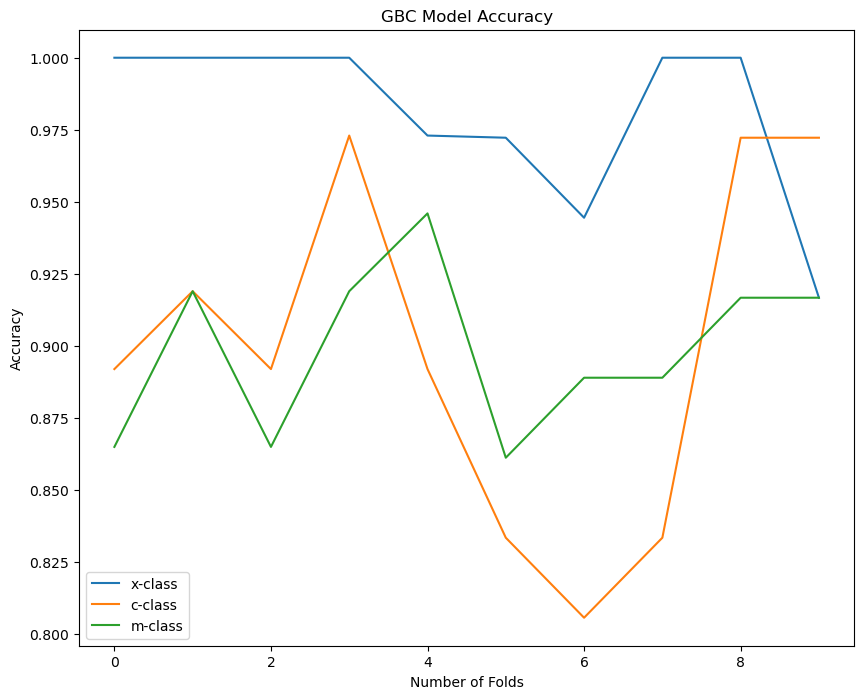

In [51]:
# Visualization of x_class_accuracy_gbc, c_class_accuracy_gbc, and m_class_accuracy_gbc
def plot_accuracy():
    plt.figure(figsize=(10, 8))
    plt.plot(x_class_accuracy_gbc[1], label='x-class')
    plt.plot(c_class_accuracy_gbc[1], label='c-class')
    plt.plot(m_class_accuracy_gbc[1], label='m-class')
    plt.title('GBC Model Accuracy')
    plt.xlabel('Number of Folds')
    plt.ylabel('Accuracy')
    plt.legend()
    plt.show()

plot_accuracy()